# Simulation of the Blume–Easley and related models

In [1]:
from math import *
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

## Main functions

In [2]:
def blume_easley_payoffs(N, T, M=None, shift=0, normed=True):
    """Simulates payoffs in the Blume-Easley model with equal probabilities.

    This function returns M trajectories of the payoff sequence of length T in
    the Blume-Easley model with N assets which make payoffs with equal
    probabilities 1/N. 
    
    The standard Blume-Easley model (shift=0) assumes that the payoff vector
    `X_t = (X_t^1, ..., X_t^N)` has only one 1 and all other 0's. If non-zero
    scalar `shift` parameter is passed, then it is added to all the components,
    e.g. the function returns (X_t^1 + shift, ..., X_t^N + shift)`.

    If `normed` is True, the payoff vectors are normed so that the sum of the
    components is 1 (makes sense only if shift is non-zero).

    Args:
        N: Number of assets (int).
        T: number of time periods (int).
        M: Number of trajectories (int). If None, then one trajectory.
        shift: Shift parameter (float).
        normed: Should the output be normed (bool).

    Returns:
        If M is not None, an array of shape (M,T,N) with simulated trajectories.
        If M is None, simulates one trajectory and returns an array of shape
        (T,N).
    """
    M_ = 1 if M is None else M
    x = np.random.randint(0, N, size=(M_,T))

    if normed:
        base_values = shift/(N*shift+1)
        add_value = 1/(N*shift+1)
    else:
        base_values = shift
        add_value = 1

    X = np.zeros(shape=(M_,T,N)) + base_values
    for m in range(M_):
        for t in range(T):
            X[m,t,x[m,t]] += add_value

    if M is None:
        return X[0]
    return X


def evolution(strategies, initial_wealth, payoffs):
    """Simulates the evolution of wealth in the model with short-lived assets.

    Given one trajectory of a payoff sequence, a vector of initial wealth, and
    a matrix of strategies, computes the trajectories of the agents' wealth.

    Args:
        strategies: KxN array of agents' strategies, where K is the number
            of agents, N is the number of assets (each row represents one
            strategy).
        initial_wealth: Vector of initial wealth (array of length N).
        payoffs: TxN array of payoffs.

    Returns:
        A tuple (W, L), where
        - W is a (T+1)xK array of agent's relative wealth (market share) from
            t=0 to t=T (inclusively),
        - L is a (T+1)xN array with the components of the representative
            strategy of the agents.
    """
    T = len(payoffs)                # time periods
    K = len(strategies)             # number of agents
    N = len(strategies[0])          # number of assets
    W = np.empty(shape=(T+1,K))     # agents' wealth
    W[0] = np.array(initial_wealth)/sum(initial_wealth)

    L = np.empty(shape=(T+1,N))     # representative strategy
    
    for t in range(T):
        L[t] = np.dot(W[t], strategies)
        for k in range(K):
            W[t+1,k] = W[t,k] * np.dot(strategies[k]/L[t], payoffs[t])

    L[T] = np.dot(W[T], strategies)

    return W, L

## Examples

### Standard Blume–Easley (without shift)

The goal of the example is to show that we always have the convergence to the strategy which is closest to the optimal one.

We consider two assets. By the symmetry of the model, the optimal strategy is [0.5, 0.5]. In the first example, there is an agent who uses the optimal strategy, in the second example none of the agents uses the optimal strategy, but the convergence still takes place.

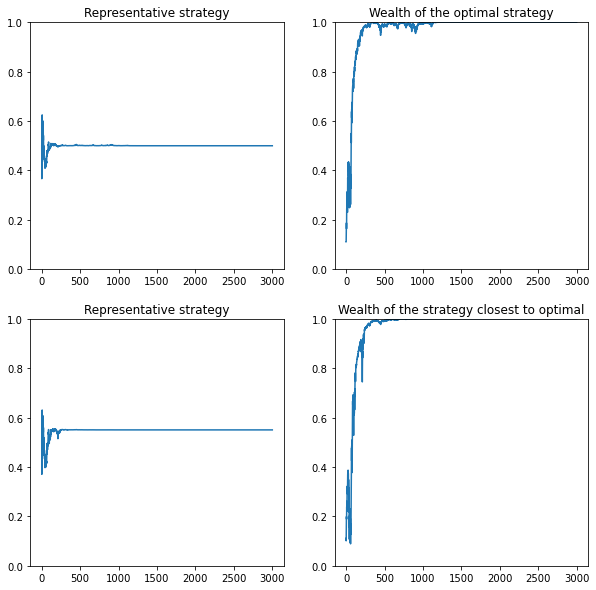

In [3]:
payoffs = blume_easley_payoffs(2, 3000)

# K-1 agents with strategies [i/K, 1 - i/K], i = 1,...,K-1
# K must be even for the optimal strategy to be included
K = 10
K_opt = K//2 - 1   # index of the optimal strategy [0.5, 0.5]
initial_wealth = [1]*(K-1)
strategies = [[i/K, 1-i/K] for i in range(1,K)]

# Simulation with optimal strategy
W, L = evolution(strategies, initial_wealth, payoffs)

# Simulation without optimal strategy
strategies[K_opt] = [0.55, 0.45]
W2, L2 = evolution(strategies, initial_wealth, payoffs)

_, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].plot(L[:,0])
ax[0,0].title.set_text("Representative strategy")
ax[0,0].set_ylim(0,1)
ax[0,1].plot(W[:,K_opt])
ax[0,1].title.set_text("Wealth of the optimal strategy")
ax[0,1].set_ylim(0,1)

ax[1,0].plot(L2[:,0])
ax[1,0].title.set_text("Representative strategy")
ax[1,0].set_ylim(0,1)
ax[1,1].plot(W2[:,K_opt])
ax[1,1].title.set_text("Wealth of the strategy closest to optimal")
ax[1,1].set_ylim(0,1)

plt.show()

### Blume–Easley with shift

Now we show that when the assets can make payoffs simultaneously (we'll use the Blume-Easley model with shift), then there may be no convergence if nobody uses the optimal strategy. 

There will be 3 graphs:
1. The optimal strategy is present, we have the convergence
1. Instead of the optimal strategy, we add a slightly altered optimal strategy $[0.5 + \epsilon, 0.5 - \epsilon]$
1. Instead of the optimal strategy, we add a not-slightly altered strategy $[0.5 + \Delta, 0.5 - \Delta]$, where $\Delta > \epsilon$

The point is that we will still have the convergence without the optimal strategy only if $\epsilon$ is small.

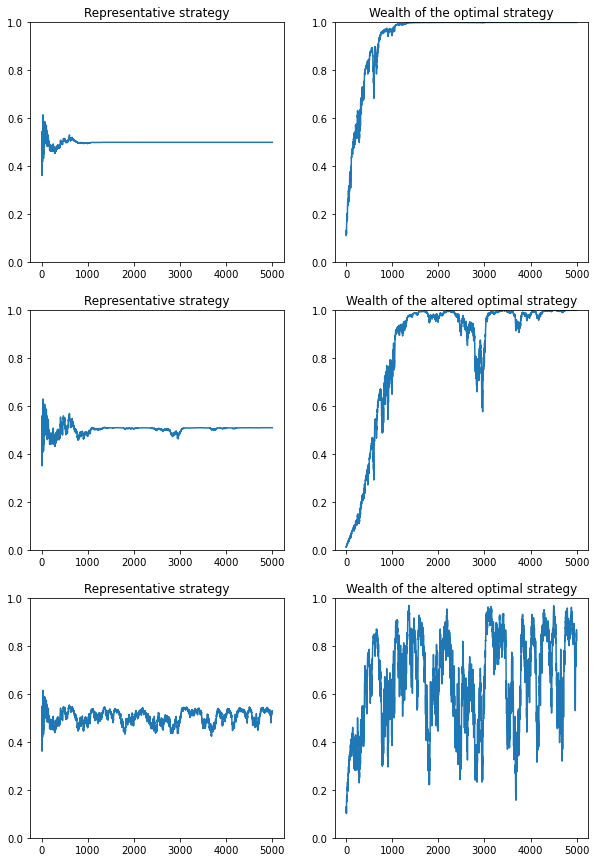

In [6]:
payoffs = blume_easley_payoffs(2, 5000, shift=0.5)

K = 10
K_opt = K//2-1
initial_wealth = [1]*(K-1)
strategies = [[i/K, 1-i/K] for i in range(1,K)]

# Simulation with optimal strategy 
# (convergence)
W, L = evolution(strategies, initial_wealth, payoffs)

# Simulation with slightly altered optimal strategy, which has small initial wealth
# (convergence)
strategies[K_opt] = [0.51,0.49]
initial_wealth[K_opt] = 0.1
W1, L1 = evolution(strategies, initial_wealth, payoffs)

# But if we change the optimal strategy too much, there will be no convergence
# (no convergence)
strategies[K_opt] = [0.55,0.45]
initial_wealth[K_opt] = 1
W2, L2 = evolution(strategies, initial_wealth, payoffs)

_, ax = plt.subplots(3, 2, figsize=(10,15))
ax[0,0].plot(L[:,0])
ax[0,0].title.set_text("Representative strategy")
ax[0,0].set_ylim(0,1)
ax[0,1].plot(W[:,K_opt])
ax[0,1].title.set_text("Wealth of the optimal strategy")
ax[0,1].set_ylim(0,1)

ax[1,0].plot(L1[:,0])
ax[1,0].title.set_text("Representative strategy")
ax[1,0].set_ylim(0,1)
ax[1,1].plot(W1[:,K_opt])
ax[1,1].title.set_text("Wealth of the altered optimal strategy")
ax[1,1].set_ylim(0,1)

ax[2,0].plot(L2[:,0])
ax[2,0].title.set_text("Representative strategy")
ax[2,0].set_ylim(0,1)
ax[2,1].plot(W2[:,K_opt])
ax[2,1].title.set_text("Wealth of the altered optimal strategy")
ax[2,1].set_ylim(0,1)

plt.show()